In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

nltk.download('vader_lexicon')
nltk.download('punkt_tab')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
df = pd.read_csv('reviews (1).csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  487 non-null    object 
 1   rating  522 non-null    float64
 2   time    522 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 12.4+ KB


In [ ]:
df.head()

,review,rating,time
0,I went to this bank branch today because I for...,2.2,1732157653
1,I wanted 2 rolls of quarters. There was no lin...,2.2,1731438158
2,Absolute worst automated customer service phon...,2.2,1735543515
3,Most of the advisors are unprofessional and be...,2.2,1728780680
4,Tried to give RBC my business and they botched...,2.2,1718167333


In [ ]:
df = df.drop(columns=['time'])


In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
  if not isinstance(text, str):
    return ""
  text=text.lower()
  text = re.sub(r"http\S+|www\S+", "", text)
  text=re.sub(r"[^a-zA-Z\s]", "", text)
  tokens=word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]
  return " ".join(tokens)

In [ ]:
df["clean_review"] = df["review"].apply(clean_text)

In [ ]:
df.head()

,review,rating,clean_review
0,I went to this bank branch today because I for...,2.2,went bank branch today forgot set pin rbc mast...
1,I wanted 2 rolls of quarters. There was no lin...,2.2,wanted rolls quarters line debit card ready mi...
2,Absolute worst automated customer service phon...,2.2,absolute worst automated customer service phon...
3,Most of the advisors are unprofessional and be...,2.2,advisors unprofessional behave rudely dont kno...
4,Tried to give RBC my business and they botched...,2.2,tried give rbc business botched possible ways ...


In [ ]:
sia = SentimentIntensityAnalyzer()
df["sentiment_score"] = df["clean_review"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["sentiment"] = df["sentiment_score"].apply(lambda x: "positive" if x >= 0.05 else ("negative" if x <= -0.05 else "neutral"))

<ipython-input-86-fc392522e869>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["sentiment"], palette="coolwarm")


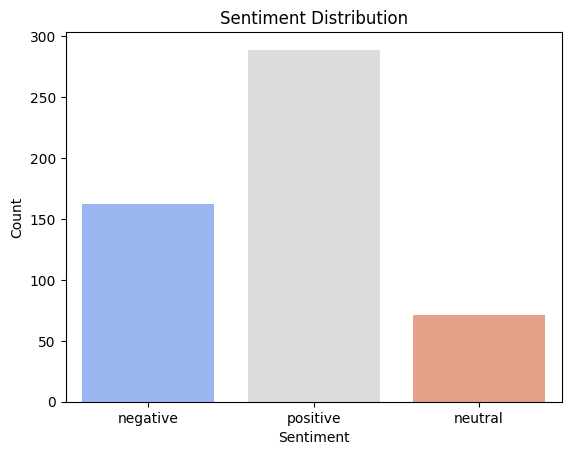

In [ ]:
sns.countplot(x=df["sentiment"], palette="coolwarm")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

**Sentiment Distribution**
- The positive catergory is most frequent with nearly 300 instances.
- The negative setiment come second with about 150 instances.
- The Neutral sentiment is the lease frequent with only around 70 instances.

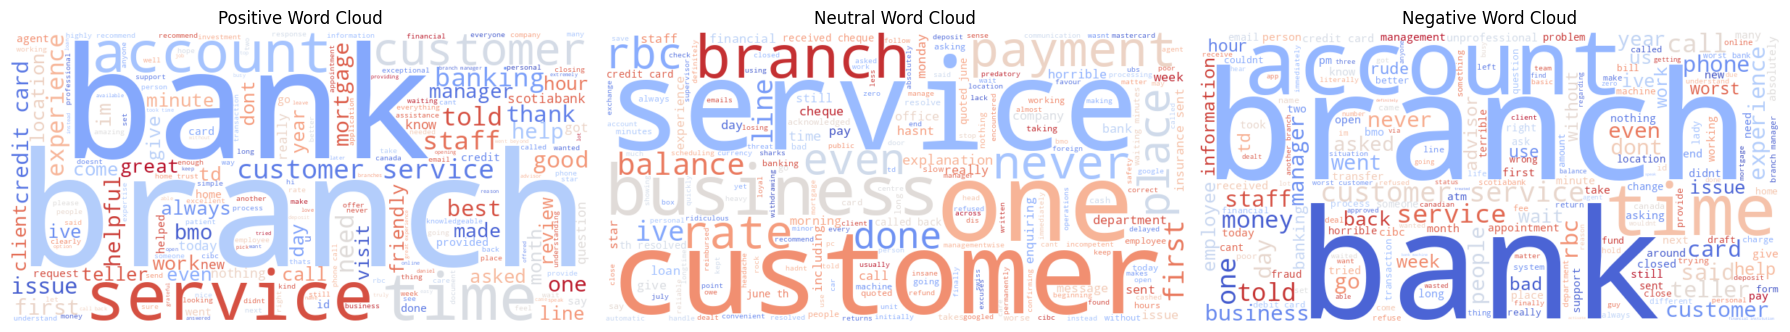

In [ ]:
from wordcloud import WordCloud

sentiments = ['positive', 'neutral', 'negative']
fog,axes = plt.subplots(1,3, figsize=(18,6))

for i, sentiment in enumerate(sentiments):
  wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate(" ".join(df[df['sentiment'] == sentiment]['clean_review']))
  axes[i].imshow(wordcloud, interpolation='bilinear')
  axes[i].set_title(f"{sentiment.capitalize()} Word Cloud")
  axes[i].axis('off')

plt.tight_layout()
plt.show()


- The positive word cloud shows that key words associated with positive reviews include "service", "Staff", and "customer".
- The negatice word cloud also includes "issue", "worst" and "never".
- The neutral has overlapping both positive and negative categories which is why the model struggles to classify neutral sentiments correctly.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["clean_review"])
y = df["sentiment"].apply(lambda x: 1 if x == "positive" else (0 if x == "neutral" else -1))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Report:", report)


Accuracy: 0.7047619047619048
Report:               precision    recall  f1-score   support

          -1       0.91      0.55      0.69        38
           0       1.00      0.13      0.24        15
           1       0.64      0.98      0.77        52

    accuracy                           0.70       105
   macro avg       0.85      0.56      0.57       105
weighted avg       0.79      0.70      0.67       105



- **Accuracy: 70%**
  - This is a moderate performance, indicating room for improvement
- **Precision & Recall:**
  - **Negative Sentiment:** High precision (91%) but low recall (55%)
  => the model is confident when it classifies a review as negative but it misses many negative reviews.
  - **Neutral Sentiment:** Very poor recall (13%) => The model almost never correctly predicts neutrasentiment.
  - **Positive Sentiment:** Lower precision (64%) but very high recall (98%) => The model tends to classify many thing as positive leading to high recall but some false postitives
- **F1-score:** The model performs best for positive sentiment (0.77) but much worse for neutral (0.24).

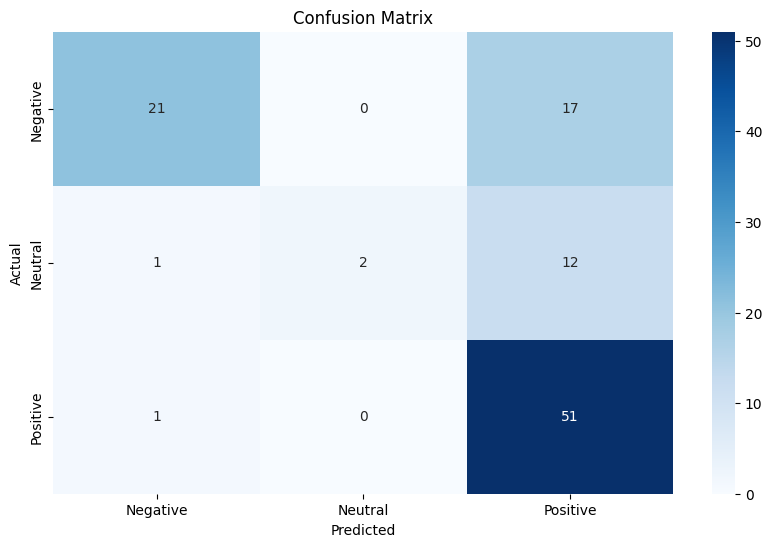

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()